In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import sys
from tqdm import tqdm
import psix

cm = 1/2.54

plt.rcParams["axes.edgecolor"]sc = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

# Running Psix in mouse midbrain neurons

Here we analyse a smart-seq2 dataset from [Tiklova et al (2019)](https://www.nature.com/articles/s41467-019-08453-1) that follows the development of brain neurons at different stages of development: E13.5, E15.5, E18.5, P0, P7, P15 and P90.

This dataset originally consists of 1699 cells. However, after quality control and normalization, we removed many cells that either had poor coverage, or that were found to be non-neural cells (mostly oligodendrocytes). This left a total of 1067 single neurons. After preprocessing, we observe a clear trajectory of neuron development in this dataset:

<img src="psix_output/plots/PCA_neurogenesis3D_legend.png" width="500"/>

The alignment data necessary to run Psix is provided in ```'data/'```: 

* ```data/SJ_tables/``` contains the SJ.out.tab produced directly from STAR alignment of the raw reads to the mm10 genome.
* ```data/mm10_introns.tab.gz``` is the cassette exon intron annotation, downloaded from https://github.com/lareaulab/psix
* ```data/tpm.tab.gz``` is a TPM file obtained with running RSEM with STAR alignment to the mm10 genome.

We preprocessed the splice junctions and TPM counts with the following command:

```python
psix_object = psix.Psix()
psix_object.junctions2psi(
        'data/SJ_tables/',
        'data/mm10_introns.tab.gz',
        'data/tpm.tab.gz',
        save_files_in='psix_output/psix_object/'
    )
```

This results in two tables:
* ```psix_output/psix_object/psi.tab.gz```, the $\hat{\Psi}$ of observed cassette exons in the dataset.
* ```psix_output/psix_object/mrna.tab.gz```, the estimated mRNA counts per exon observed in the dataset.



In [3]:
# psix_object = psix.Psix()
# psix_object.junctions2psi(
#         'data/SJ_tables/',
#         'data/mm10_introns.tab.gz',
#         'data/tpm.tab.gz',
#         save_files_in='psix_output/psix_object/'
#     )

100%|██████████| 1067/1067 [02:50<00:00,  6.26it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:47<00:00, 22.47it/s]


Successfully processed RNA-seq data


Once we have produced the $\hat{\Psi}$ and mRNA tables, we can run Psix. Next time we run Psix, we can also skip the latest step by creating a Psix object directly from the $\hat{\Psi}$ and mRNA tables as follows (this step is not necessary after running ```junctions2psi```):

In [ ]:
psix_object = psix.Psix(psi_table = 'psix_output/psix_object/psi.tab.gz',
                        mrna_table = 'psix_output/psix_object/mrna.tab.gz')

## Identifying cell-state associated exons with Psix

For running Psix, we need a metric that indicates the phenotypic of the individual cells. In this case, we use the PCA of the normalized gene expression, which is located at ```data/pc3_rd.tab.gz```.

In [2]:
psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25)

Computing cell-cell metric...


100%|██████████| 1067/1067 [00:00<00:00, 1948.01it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:19<00:00, 107.05it/s]


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [08:19<00:00, 19.96s/it]  


Successfully estimated p-values


### Psix results

Running Psix creates ```psix_object.psix_results```, a dataframe with the Psix score ($\Psi_\xi$) of every exon, its empirical $p$-value, and it's $q$-value after Benjamini-Hochberg correction. These are the top scoring exons:

In [3]:
psix_object.psix_results.head(n=10)

,psix_score,pvals,qvals
Mapt_1,2.709381,0.0005,0.001879
Ndrg4_1,2.359093,0.0005,0.001879
Dbn1_1,2.302729,0.0005,0.001879
Mapt_3,1.964202,0.0005,0.001879
Gabrg2_1,1.896363,0.0005,0.001879
Cadm1_10,1.576869,0.0005,0.001879
Ncam1_6,1.456006,0.0005,0.001879
Dst_5,1.449287,0.0005,0.001879
Cadm1_3,1.411169,0.0005,0.001879
Morf4l2_7,1.363965,0.0005,0.001879


We visualize the top scoring exons, and indicate the score of some cassette exons that are known to change during neurogenesis (this plot is not a Psix feature).

100%|██████████| 2087/2087 [00:10<00:00, 189.95it/s]


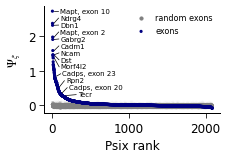

In [4]:
psix_results = psix_object.psix_results
psix_results['bins'] = ['']*len(psix_results.index)

for mean in psix_object.bins.keys():
    for var in psix_object.bins[mean].keys():
        for exon in psix_object.bins[mean][var]:
            psix_results.loc[exon, 'bins'] = mean +'_' + var
            
fig = plt.figure(figsize=(8*cm, 5*cm))
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons', s=10)

for mean_var in tqdm(psix_results.sort_values('psix_score')[::-1].bins):
    mean = mean_var[:6]
    var = mean_var[7:]
    subset = np.random.choice(psix_object.random_scores[mean][var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02, s=10, edgecolors='none')
    i += 1


plt.text(100, psix_results.loc['Mapt_1'].psix_score-0.05, 'Mapt, exon 10', c='black', fontsize=7)   
ax.plot([20, 80], [psix_results.loc['Mapt_1'].psix_score, psix_results.loc['Mapt_1'].psix_score],c='black', linewidth=0.7)

plt.text(101, psix_results.loc['Mapt_1'].psix_score-0.25, 'Ndrg4', c='black', fontsize=7)   
ax.plot([20, 81], [psix_results.loc['Ndrg4_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.2],c='black', linewidth=0.7)

plt.text(102, psix_results.loc['Mapt_1'].psix_score-0.45, 'Dbn1', c='black', fontsize=7)   
ax.plot([20, 82], [psix_results.loc['Dbn1_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.4],c='black', linewidth=0.7)

plt.text(103, psix_results.loc['Mapt_1'].psix_score-0.65, 'Mapt, exon 2', c='black', fontsize=7)    
ax.plot([24, 83], [psix_results.loc['Mapt_3'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.6],c='black', linewidth=0.7)

plt.text(104, psix_results.loc['Mapt_1'].psix_score-0.85, 'Gabrg2', c='black', fontsize=7)   
ax.plot([25, 84], [psix_results.loc['Gabrg2_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.8],c='black', linewidth=0.7)

plt.text(105, psix_results.loc['Mapt_1'].psix_score-1.05, 'Cadm1', c='black', fontsize=7)    
ax.plot([24, 85], [psix_results.loc['Cadm1_10'].psix_score, psix_results.loc['Mapt_1'].psix_score-1],c='black', linewidth=0.7)

plt.text(106, psix_results.loc['Mapt_1'].psix_score-1.25, 'Ncam', c='black', fontsize=7)   
ax.plot([25, 86], [psix_results.loc['Ncam1_6'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.2],c='black', linewidth=0.7)

plt.text(107, psix_results.loc['Mapt_1'].psix_score-1.45, 'Dst', c='black', fontsize=7)    
ax.plot([24, 87], [psix_results.loc['Dst_5'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.4],c='black', linewidth=0.7)

plt.text(109, psix_results.loc['Mapt_1'].psix_score-1.65, 'Morf4l2', c='black', fontsize=7)   
ax.plot([25, 89], [psix_results.loc['Morf4l2_7'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.6],c='black', linewidth=0.7)

plt.text(129, psix_results.loc['Mapt_1'].psix_score-1.85, 'Cadps, exon 23', c='black', fontsize=7)   
ax.plot([55, 109], [psix_results.loc['Cadps_7'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.8],c='black', linewidth=0.7)


plt.text(177, psix_results.loc['Mapt_1'].psix_score-2.05, 'Rpn2', c='black', fontsize=7)   
ax.plot([65, 157], [psix_results.loc['Rpn2_3'].psix_score, psix_results.loc['Mapt_1'].psix_score-2],c='black', linewidth=0.7)

plt.text(214, psix_results.loc['Mapt_1'].psix_score-2.25, 'Cadps, exon 20', c='black', fontsize=7)   
ax.plot([105, 194], [psix_results.loc['Cadps_2'].psix_score, psix_results.loc['Mapt_1'].psix_score-2.2],c='black', linewidth=0.7)

plt.text(331, psix_results.loc['Mapt_1'].psix_score-2.45, 'Tecr', c='black', fontsize=7)   
ax.plot([125, 311], [psix_results.loc['Tecr_6'].psix_score, psix_results.loc['Mapt_1'].psix_score-2.4],c='black', linewidth=0.7)

ax.scatter(np.arange(1, len(psix_results.index)+1), psix_results.sort_values('psix_score')[::-1].psix_score, c = 'navy',
          label='exons', s=10, zorder=200, edgecolors='none')
    
plt.xlabel('Psix rank', fontsize=12)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=12, length=5)
plt.legend(frameon=False, fontsize=8)

plt.savefig('psix_output/plots/psix_scores.png', bbox_inches='tight', res=20000, dpi =2000)

### Gene ontology enrichment analysis 

We rank the genes that contain the top scoring exons, and run a GO enrichment analysis on Panther.

In [13]:
psix_results = psix_object.psix_results
from tqdm import tqdm
gene_list = []
score_list = []
for idx, row in tqdm(psix_results.iterrows()):
    gene = idx.split('_')[0]
    if gene in gene_list:
        continue
    else:
        gene_list.append(gene)
        score_list.append(row.psix_score)
        
with open('psix_output/go_analysis/psix.rnk', 'w') as fh:
    for i in range(len(gene_list)):
        line = gene_list[i] + '\t' + str(score_list[i]) + '\n'
        fh.write(line)

2087it [00:00, 6107.22it/s]


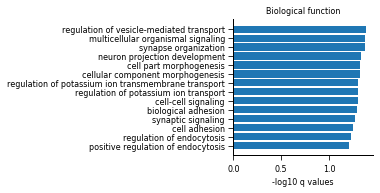

In [16]:
go_bio = pd.read_csv('psix_output/go_analysis/analysis_go_biological_function.txt', 
                     sep='\t', index_col=0, skiprows=4).sort_values('fdr')[::-1]
idx = [x.split(' (')[0] for x in go_bio.index]
go_bio.index = idx


fig = plt.figure(figsize=(6/2.4, 6/2.4))
ax = fig.add_subplot(111)
ax.barh(go_bio.index, -np.log10(go_bio.fdr))
ax.set_xlabel('-log10 q values', size=8)
# ax.set_ylabel('PC 2', size=18)
ax.set_title('Biological function', size=8)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='x', labelsize=8, length=5)
ax.tick_params(axis='y', labelsize=8, length=5)
plt.savefig('psix_output/plots/GO_biological_function.png', bbox_inches='tight', res=20000, dpi =2000)


## Identifying modules of correlated exons with Psix

Once we have identified the cell-state associated exons, we can obtain modules of exons correlated across the cell-state space. If we chose, we can also generate a heatmap of the correlation between exons, associated in modules.

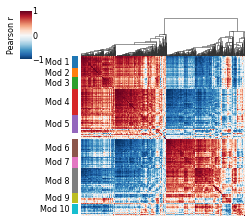

In [29]:
psix_object.compute_modules(plot = True, plot_name = 'psix_output/plots/exon_modules.png')

The modules for each cell-state associated exon can be found at ```psix_object.modules```. Each module is assigned an integer. Exons that are not assigned to any module are labeled with -1.

In [17]:
psix_object.modules

Slc30a9_1        1
Slc30a9_2        1
Cnot2_nmdSE_1    1
Cnot2_nmdSE_2    1
Xpa_nmdSE_1      1
                ..
Mrpl55_1        -1
Trub2_2         -1
Ndufaf6_2       -1
Ncald_7         -1
Slc39a9_2       -1
Name: Modules, Length: 798, dtype: int64

## Saving a Psix object

Finally, we can save the results from Psix for future uses.

In [6]:
psix_object.save_psix_object(psix_dir = 'psix_output/psix_object/', overwrite=True)

Next time we need to run Psix, we can load the results of the previous run (including the $\hat{\Psi}$ and mRNA tables, the Psix scores, and modules) by creating a new Psix object as follows:

In [10]:
psix_object = psix.Psix(psix_object = 'psix_output/psix_object/')

# Splicing factor binding and correlation

Next we investigated what are the potential regulators of the cell-state associated exons. 

In [18]:
from scipy.stats import hypergeom
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from statsmodels.stats.multitest import multipletests

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm


In [19]:
psix_object.latent = pd.read_csv('data/pc3_rd.tab.gz', sep='\t', index_col=0)
psix_results = psix_object.psix_results
norm_expression = pd.read_csv('data/preprocess/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)[psix_object.latent.index]
# norm_expression = pd.read_csv('data/preprocess/scone_norm_tpm.tab.gz', sep='\t', index_col=0)[psix_object.latent.index]
psi = psix_object.adata.uns['psi'].T
modules = psix_object.modules
clip_dir = 'data/'

We are interested in finding which splicing factors regulate the cell-state associated exons that we identified with Psix. In order to do that, we use CLIP-seq data for the splicing factors of interest. We indicate if a splicing factor is bound to the exon, if we observe a CLIP-seq peak overlaping with any of the following four regions:


* E1 region: 100 nt upstream and $i_1$ nt downstream from the splice junction of the upstream flanking exon. Where $i_1$ is the minimum of 100 and half the distance between the upstream flanking exon and the cassette exon.
* S1 region: $i_1$ nt upstream and $e$ nt downstream from the 5' splice junction of the cassette exon. Where $e$ is the minimum of 100 and half the distance between the two splice junctions of the cassette exon.
* S2 region: $e$ nt upstream and $i_2$ nt downstream from the 3' splice junction of the cassette exon. Where $i_2$ is the minimum of 100 and half the distance between the cassette exon and the downstream flanking exon.
* E2 region: $i_2$ nt upstream and 100 nt downstream from the splice junction of the downstream flanking exon.

This data is available in ```data/rbp_binding/peaks_clip_tags_overlap_len.tab.gz```. 

We use a hypergeometric test to test if the set of cell-state associated exons are enriched for each splicing factor, compared with the total exons we tested: 

In [21]:
# clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv('data/rbp_binding/peaks_clip_tags_overlap_len.tab.gz', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']

new_idx = [x[:-3] for x in mouse_clip_peaks.index if x[-3:] == '_e1']
mouse_clip_peaks_e1 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_e1']]
mouse_clip_peaks_s1 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_s1']]
mouse_clip_peaks_s2 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_s2']]
mouse_clip_peaks_e2 = mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:] == '_e2']]

mouse_clip_peaks_e1.index = new_idx
mouse_clip_peaks_s1.index = new_idx
mouse_clip_peaks_s2.index = new_idx
mouse_clip_peaks_e2.index = new_idx

mouse_clip_peaks_any = ((mouse_clip_peaks_e1 + mouse_clip_peaks_s1 + mouse_clip_peaks_s2 + mouse_clip_peaks_e2) > 0).astype(int)


# We exclude a few RNA binding proteins that are not splicing factors 

remove = ['EZH2', 'AGO2', 'LIN28A', 'CIRBP', 'FMR1', 'TAF15', 'UPF1']
splicing_factors =  [x for x in mouse_clip_peaks_any.columns if x not in remove]

mouse_clip_peaks_any[splicing_factors]

sig_exons = psix_results.loc[(psix_results.qvals <= 0.05) & (psix_results.psix_score > 0)].index

pval_hyper = []
enrichment_hyper = []

for RBP in splicing_factors:
        
    region_exons = mouse_clip_peaks_any.index

    hyper = test_enrichment(mouse_clip_peaks_any.loc[psix_results.index, RBP], sig_exons)
    pval_hyper.append(hyper[0])
    enrichment_hyper.append(hyper[2])
    
print('Significantly bound splicing factors:\n')
for sf in sorted(np.array(splicing_factors)[multipletests(pval_hyper, method='fdr_bh')[0]]):
    print(sf)


Significantly bound splicing factors:

CELF4
FUS
MBNL1MBNL2
MBNL2
NOVA1
NOVA2
PTBP2
RBFOX1
RBFOX2
RBFOX3
SRSF3
SRSF4
SRSF5
SRSF6
TARDBP
U2AF2


Now we check the correlation between the expression of the splicing factors, and the $\hat{\Psi}$ of the exons in each module.

In [22]:
module_avg = pd.DataFrame()


sf_list = ['Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp1', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2']

sf_list = [x for x in sf_list if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list), len(module_avg.index))), 
                               index = sf_list, columns = module_avg.index)
for sf in tqdm(sf_list):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
mod_order = ['module_1', 'module_2', 'module_3', 'module_4', 'module_5',
             'module_6', 'module_7', 'module_8', 'module_9', 'module_10']

mod_cor = module_avg_corr.loc[sf_list, mod_order]
mod_cor.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
             'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

100%|██████████| 20/20 [00:00<00:00, 59.41it/s]


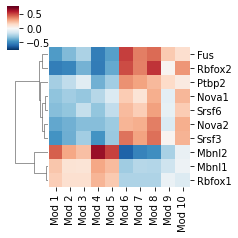

In [23]:
module_avg_corr.columns = ['Mod 1', 'Mod 2', 'Mod 3', 'Mod 4', 'Mod 5',
             'Mod 6', 'Mod 7', 'Mod 8', 'Mod 9', 'Mod 10']

sf_list = [x for x in module_avg_corr.index if x in ['Celf4', 'Fus', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 'Ptbp2',
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf3', 'Srsf4', 'Srsf5', 'Srsf6', 'Tardp', 'U2af2']]

module_avg_corr = module_avg_corr.loc[sf_list]

sns.clustermap(module_avg_corr.loc[module_avg_corr.abs().max(axis=1) >= 0.25], 
               col_cluster=False,
               row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r', figsize=(8/2.4, 8/2.4))

plt.savefig('psix_output/plots/module_correlations.png', bbox_inches='tight', res=20000, dpi =2000)

# Exon modules in adult midbrain cells

We run Psix in the subset of cells corresponding to the postnatal day 90 (adult) midbrain. We can do thins by passing the argument ```cell_list``` when creating a Psix object.

In [24]:
p90_cells = []
with open('data/p90_cells.txt', 'r') as fh:
    for cell in fh:
        p90_cells.append(cell.rstrip())
        
psix_p90 = psix.Psix()
psix_p90.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        cell_list = p90_cells,
        save_files_in='psix_output/psix_object_p90/'
    )

100%|██████████| 290/290 [00:50<00:00,  5.73it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 290/290 [00:14<00:00, 20.69it/s]


Successfully processed RNA-seq data


We reduce the neighborhood size to increase sensitivity, in the smaller group of cells.

In [ ]:
psix_p90.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=2000, n_neighbors=30)#, pvals_bins=10)

Computing cell-cell metric...


100%|██████████| 290/290 [00:00<00:00, 18646.49it/s]

Successfully computed cell-cell metric
Computing Psix score in 2115 exons



100%|██████████| 2115/2115 [00:07<00:00, 267.19it/s] 


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


 24%|██▍       | 6/25 [01:50<16:37, 52.52s/it]

### Modules of exons in P90 cells

In [ ]:
psix_p90.compute_modules(z_threshold=0.1, 
                         plot = True,
                         plot_name = 'psix_output/plots/exon_modules_p90.png')

In [ ]:
sig_exons = psix_p90.psix_results.index[(psix_p90.psix_results.qvals <= 0.05) & (psix_p90.psix_results.psix_score >= 0)]
psix_p90.adata.uns['neighbors_psi'][sig_exons]
p90_eig = (np.linalg.eig(psix_p90.adata.uns['neighbors_psi'][sig_exons].corr().fillna(0))[0]**2)
print(p90_eig[0]/np.sum(p90_eig))

### Splicing in earlier stages of development

We use Psix to get the $\hat{\Psi}$ tables in the postnatal day 1 (P1) and embryonic day 13.5 (E13.5) cells.

In [11]:
p1_cells = []
with open('data/p1_cells.txt', 'r') as fh:
    for cell in fh:
        p1_cells.append(cell.rstrip())
        
psix_p1 = psix.Psix()
psix_p1.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        cell_list = p1_cells,
        save_files_in='psix_output/psix_object_p1/',
        minPsi = 0.001,
        min_observed = 0.001,
    )

100%|██████████| 242/242 [00:40<00:00,  5.96it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 242/242 [00:10<00:00, 23.54it/s]


Successfully processed RNA-seq data


In [12]:
e13_cells = []
with open('data/e13_cells.txt', 'r') as fh:
    for cell in fh:
        e13_cells.append(cell.rstrip())
        
psix_e13 = psix.Psix()
psix_e13.junctions2psi(
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/SJ_tables/midbrain_neurons/',
        '/mnt/lareaulab/cfbuenabadn/Genomes/pipeline_files/mm10_introns.tab',
        '/mnt/lareaulab/cfbuenabadn/RNASeq/Mouse/Tiklova/tpm.tab.gz',
        cell_list = e13_cells,
        save_files_in='psix_output/psix_object_e13/',
        minPsi = 0.001,
        min_observed = 0.001,
    )

100%|██████████| 240/240 [00:34<00:00,  6.88it/s]


Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 240/240 [00:09<00:00, 26.36it/s]


Successfully processed RNA-seq data


Successfully computed neighbors


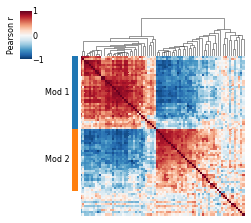

0.9004344092540871


We want to see the splicing patterns of the two P90 modules, in the earlier stages of development. We compute the neighbor $\bar{\Psi}$, but we do not need to run Psix on these stages.

In [15]:
psix_p1.compute_neighbors_psi(latent='data/pc3_rd.tab.gz', n_neighbors=30)
psix_e13.compute_neighbors_psi(latent='data/pc3_rd.tab.gz', n_neighbors=30)

100%|██████████| 242/242 [00:00<00:00, 10168.62it/s]

Successfully computed cell-cell metric



100%|██████████| 240/240 [00:00<00:00, 19725.14it/s]

Successfully computed neighbors
Successfully computed cell-cell metric


Successfully computed neighbors


0.5456391992622467


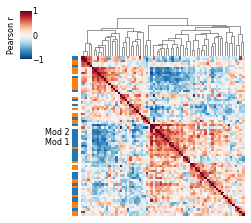

In [16]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & psix_p1.adata.uns['psi'].columns

background_psi = psix_p1.adata.uns['neighbors_psi'].mask(psix_p1.adata.uns['psi'].isna()).T

bwow_p1 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_p1[0].index], bwow_p1[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'psix_output/plots/exon_modules_p1.png', shrink_by=1#/0.5
)

p1_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
print(p1_eig[0]/np.sum(p1_eig))

0.3887988927799862


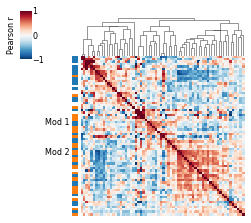

In [17]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *


psix_results = psix_p90.psix_results

background_psi = psix_p90.adata.uns['neighbors_psi'].mask(psix_p90.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow_p90 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)


exon_list = exon_list & psix_e13.adata.uns['psi'].columns

background_psi = psix_e13.adata.uns['neighbors_psi'].mask(psix_e13.adata.uns['psi'].isna()).T

bwow_e13 = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.1, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow_p90[0].loc[bwow_e13[0].index], bwow_e13[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'psix_output/plots/exon_modules_e13.png', shrink_by=1#/0.5
)

e13_eig = (np.linalg.eig(background_psi.loc[exon_list].T.corr().fillna(0))[0]**2)
print(e13_eig[0]/np.sum(e13_eig))

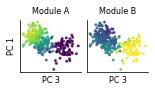

In [18]:
from itertools import product
from matplotlib.gridspec import GridSpec

latent = psix_p90.latent


fig = plt.figure(figsize=(5.5/2.4, 2.3/2.4))
gs = GridSpec(1,2)
gs.update(wspace=0.1, hspace=0.7)

    
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])

ax_1.scatter(psix_p90.latent.PC_3, psix_p90.latent.PC_1,
           c = zscore(psix_p90.adata.uns['neighbors_psi'].T.loc[psix_p90.modules.loc[psix_p90.modules == 1].index],
       axis=1, nan_policy='omit').mean(axis=0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
ax_1.set_ylabel('PC 1', fontsize=8)
ax_1.set_xlabel('PC 3', fontsize=8)

ax_1.set_xticks([])
ax_1.set_yticks([])

ax_1.spines["right"].set_visible(False)
ax_1.spines["top"].set_visible(False)
ax_1.spines['left'].set_linewidth(0.75)
ax_1.spines['bottom'].set_linewidth(0.75)
ax_1.set_title('Module A', fontsize=8)


ax_2.scatter(psix_p90.latent.PC_3, psix_p90.latent.PC_1,
           c = zscore(psix_p90.adata.uns['neighbors_psi'].T.loc[psix_p90.modules.loc[psix_p90.modules == 2].index],
       axis=1, nan_policy='omit').mean(axis=0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
# ax_2.set_ylabel('PC 1', fontsize=12)
ax_2.set_xlabel('PC 3', fontsize=8)
ax_2.set_xticks([])

ax_2.set_yticks([])
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines['left'].set_linewidth(0.75)
ax_2.spines['bottom'].set_linewidth(0.75)
ax_2.set_title('Module B', fontsize=8)

plt.savefig('psix_output/plots/p90_modules_scatterplot.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.show()

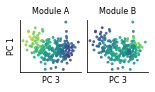

In [19]:
from itertools import product
from matplotlib.gridspec import GridSpec

latent = psix_p1.latent


fig = plt.figure(figsize=(5.5/2.4, 2.3/2.4))
gs = GridSpec(1,2)
gs.update(wspace=0.1, hspace=0.7)

    
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])

idx_1 = psix_p90.modules.loc[psix_p90.modules == 1].index & psix_p1.adata.uns['neighbors_psi'].columns


ax_1.scatter(latent.PC_3, latent.PC_1,
           c = np.nanmean(zscore(psix_p1.adata.uns['neighbors_psi'].T.loc[idx_1],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
ax_1.set_ylabel('PC 1', fontsize=8)
ax_1.set_xlabel('PC 3', fontsize=8)

ax_1.set_xticks([])
ax_1.set_yticks([])

ax_1.spines["right"].set_visible(False)
ax_1.spines["top"].set_visible(False)
ax_1.spines['left'].set_linewidth(0.75)
ax_1.spines['bottom'].set_linewidth(0.75)
ax_1.set_title('Module A', fontsize=8)



idx_2 = psix_p90.modules.loc[psix_p90.modules == 2].index & psix_p1.adata.uns['neighbors_psi'].columns


ax_2.scatter(latent.PC_3, latent.PC_1,
           c = np.nanmean(zscore(psix_p1.adata.uns['neighbors_psi'].T.loc[idx_2],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
# ax_2.set_ylabel('PC 1', fontsize=12)
ax_2.set_xlabel('PC 3', fontsize=8)
ax_2.set_xticks([])

ax_2.set_yticks([])
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines['left'].set_linewidth(0.75)
ax_2.spines['bottom'].set_linewidth(0.75)
ax_2.set_title('Module B', fontsize=8)

# plt.savefig('psix_output/plots/p1_modules_scatterplot.png', bbox_inches='tight', res=20000, dpi =2000)
plt.show()

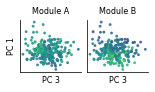

In [20]:
from itertools import product
from matplotlib.gridspec import GridSpec

latent = psix_e13.latent


fig = plt.figure(figsize=(5.5/2.4, 2.3/2.4))
gs = GridSpec(1,2)
gs.update(wspace=0.1, hspace=0.7)

    
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])

idx_1 = psix_p90.modules.loc[psix_p90.modules == 1].index & psix_e13.adata.uns['neighbors_psi'].columns


ax_1.scatter(latent.PC_3, latent.PC_1,
           c = np.nanmean(zscore(psix_e13.adata.uns['neighbors_psi'].T.loc[idx_1],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
ax_1.set_ylabel('PC 1', fontsize=8)
ax_1.set_xlabel('PC 3', fontsize=8)

ax_1.set_xticks([])
ax_1.set_yticks([])

ax_1.spines["right"].set_visible(False)
ax_1.spines["top"].set_visible(False)
ax_1.spines['left'].set_linewidth(0.75)
ax_1.spines['bottom'].set_linewidth(0.75)
ax_1.set_title('Module A', fontsize=8)



idx_2 = psix_p90.modules.loc[psix_p90.modules == 2].index & psix_e13.adata.uns['neighbors_psi'].columns


ax_2.scatter(latent.PC_3, latent.PC_1,
           c = np.nanmean(zscore(psix_e13.adata.uns['neighbors_psi'].T.loc[idx_2],
       axis=1, nan_policy='omit'), axis = 0), s=8, linewidth=0, alpha=0.9, vmin=-1, vmax=1)
# ax_2.set_ylabel('PC 1', fontsize=12)
ax_2.set_xlabel('PC 3', fontsize=8)
ax_2.set_xticks([])

ax_2.set_yticks([])
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines['left'].set_linewidth(0.75)
ax_2.spines['bottom'].set_linewidth(0.75)
ax_2.set_title('Module B', fontsize=8)

# plt.savefig('psix_output/plots/e13_modules_scatterplot.png', bbox_inches='tight', res=20000, dpi =2000)
plt.show()

## Gene markers in P90 cells

Expression of gene markers used in Tiklova et al., 2019.

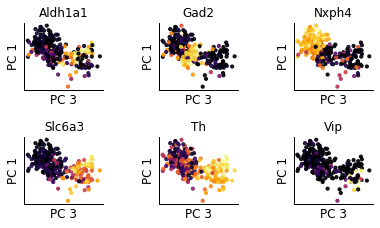

In [54]:
from itertools import product
from matplotlib.gridspec import GridSpec

latent = psix_object.latent.loc[p90_cells]

fig = plt.figure(figsize=(15/2.4, 8/2.4))
gs = GridSpec(2,3)
gs.update(wspace=0.7, hspace=0.7)

    
ax_1 = fig.add_subplot(gs[0, 0])
ax_2 = fig.add_subplot(gs[0, 1])
ax_3 = fig.add_subplot(gs[0, 2])
ax_4 = fig.add_subplot(gs[1, 0])
ax_5 = fig.add_subplot(gs[1, 1])
ax_6 = fig.add_subplot(gs[1, 2])

def plot_ax(ax, gene):
    ax.scatter(latent.PC_3, latent.PC_1,
           c = norm_expression.loc[gene, p90_cells], s=10, edgecolor=None, alpha=0.9, cmap='inferno')
    ax.set_ylabel('PC 1', fontsize=12)
    ax.set_xlabel('PC 3', fontsize=12)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(gene, fontsize=12)
    
plot_ax(ax_1, 'Aldh1a1')
plot_ax(ax_2, 'Gad2')
plot_ax(ax_3, 'Nxph4')
plot_ax(ax_4, 'Slc6a3')
plot_ax(ax_5, 'Th')
plot_ax(ax_6, 'Vip')

plt.savefig('psix_output/plots/p90_lineage_expression.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.show()

## Enrichment of splicing factor binding in cell-state associated exons in P90 cells

In [46]:
psix_results = psix_p90.psix_results

sig_exons_p90 = psix_results.loc[(psix_results.qvals <= 0.05) & (psix_results.psix_score > 0)].index

pval_hyper = []
enrichment_hyper = []

for RBP in splicing_factors:
        
    region_exons = mouse_clip_peaks_any.index

    hyper = test_enrichment(mouse_clip_peaks_any.loc[psix_results.index, RBP], sig_exons_p90)
    pval_hyper.append(hyper[0])
    enrichment_hyper.append(hyper[2])
    
print('Significantly bound splicing factors:\n')
for sf in sorted(np.array(splicing_factors)[multipletests(pval_hyper, method='fdr_bh')[0]]):
    print(sf)


Significantly bound splicing factors:

CELF4
FUS
MBNL2
NOVA1
NOVA2
RBFOX1
RBFOX2


### Correlation of bound splicing factors, with P90 modules

In [22]:
def nan_pearsonr(x, y):
    non_nan = y.dropna().index
    if len(non_nan) < 15:
        return (np.nan, 1)
    return pearsonr(x.loc[non_nan], y.loc[non_nan])

p90_modules = psix_p90.modules

from scipy.stats import ranksums
def get_corr(rbp_name):
    mod1_p90_cor = []
    mod1_p1_cor = []
    mod1_e13_cor = []
    for exon in p90_modules.loc[p90_modules == 1].index:
        mod1_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_p90.adata.uns['psi'].loc[p90_cells, exon])[0]
        )

        if exon in psix_p1.adata.uns['psi'].columns:
            mod1_p1_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_p1.adata.uns['psi'].loc[p1_cells, exon])[0]
            )

        if exon in psix_e13.adata.uns['psi'].columns:
            mod1_e13_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_e13.adata.uns['psi'].loc[e13_cells, exon])[0]
            )

    mod2_p90_cor = []
    mod2_p1_cor = []
    mod2_e13_cor = []
    for exon in p90_modules.loc[p90_modules == 2].index:
        mod2_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_p90.adata.uns['psi'].loc[p90_cells, exon])[0]
        )

        if exon in psix_p1.adata.uns['psi'].columns:
            mod2_p1_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_p1.adata.uns['psi'].loc[p1_cells, exon])[0]
            )

        if exon in psix_e13.adata.uns['psi'].columns:
            mod2_e13_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_e13.adata.uns['psi'].loc[e13_cells, exon])[0]
            )    
        
    
    modules_corr = pd.DataFrame()
    modules_corr['E13.5'] = [np.nanmean(mod1_e13_cor), np.nanmean(mod2_e13_cor)]
    modules_corr['P1'] = [np.nanmean(mod1_p1_cor), np.nanmean(mod2_p1_cor)]
    modules_corr['P90'] = [np.nanmean(mod1_p90_cor), np.nanmean(mod2_p90_cor)]
    
    modules_corr.index = ['Mod1', 'Mod2']
    
    wx_rank = []
    
    wx_rank.append(ranksums(mod1_e13_cor, mod2_e13_cor)[1])
    wx_rank.append(ranksums(mod1_p1_cor, mod2_p1_cor)[1])
    wx_rank.append(ranksums(mod1_p90_cor, mod2_p90_cor)[1])
    
    #list(p90_modules.loc[p90_modules == 1].index) + list(p90_modules.loc[p90_modules == 2].index)
    
    return modules_corr, wx_rank

In [47]:
wilcoxon_df = pd.DataFrame()
diff_df = pd.DataFrame()
for rbp in ['Celf4', 'Fus', 'Mbnl2', 'Nova1', 'Nova2', 'Rbfox1', 'Rbfox2']:
    rbp_module_corr, wilcoxon = get_corr(rbp)
    
    rbp_module_diff = rbp_module_corr.loc['Mod1'] - rbp_module_corr.loc['Mod2']
    
    diff_df[rbp] = rbp_module_diff
    
    wilcoxon_df[rbp] = wilcoxon
    
wilcoxon_df.index = ['E13.5', 'P1', 'P90']

wilcoxon_df = wilcoxon_df.T
diff_df = diff_df.T.abs()

Significant differences in splicing factor-module correlation

In [51]:
wilcoxon_corrected = pd.DataFrame(multipletests(np.array(wilcoxon_df).reshape(21, ), method='fdr_bh')[0].reshape(7, 3),
             index = wilcoxon_df.index, columns = wilcoxon_df.columns)

significant_df = wilcoxon_corrected & (diff_df >= 0.1)

significant_df.loc[significant_df.sum(axis=1)>=1]

,E13.5,P1,P90
Mbnl2,False,False,True
Nova1,False,True,True
Rbfox1,False,False,True


In [52]:
def plot_rbp_ax_uniform(rbp_name, ax):
    mod1_p90_cor = []
    mod1_p1_cor = []
    mod1_e13_cor = []
    
    for exon in p90_modules.loc[p90_modules == 1].index:
        mod1_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_p90.adata.uns['psi'].loc[p90_cells, exon])[0]
        )

        if exon in psix_p1.adata.uns['psi'].columns:
            mod1_p1_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_p1.adata.uns['psi'].loc[p1_cells, exon])[0]
            )

        if exon in psix_e13.adata.uns['psi'].columns:
            mod1_e13_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_e13.adata.uns['psi'].loc[e13_cells, exon])[0]
            )

    mod2_p90_cor = []
    mod2_p1_cor = []
    mod2_e13_cor = []
    
    nova_colors = []
    
    for exon in p90_modules.loc[p90_modules == 2].index:
        
        if exon == 'Nova1_1':
            nova_colors.append('red')
        else:
            nova_colors.append(None)
        
        
        mod2_p90_cor.append(
            nan_pearsonr(norm_expression.loc[rbp_name, p90_cells], psix_p90.adata.uns['psi'].loc[p90_cells, exon])[0]
        )

        if exon in psix_p1.adata.uns['psi'].columns:
            mod2_p1_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, p1_cells], psix_p1.adata.uns['psi'].loc[p1_cells, exon])[0]
            )

        if exon in psix_e13.adata.uns['psi'].columns:
            mod2_e13_cor.append(
                nan_pearsonr(norm_expression.loc[rbp_name, e13_cells], psix_e13.adata.uns['psi'].loc[e13_cells, exon])[0]
            )    
        
    abs_max = np.max((np.nanmax(np.abs(mod1_e13_cor)), 0))
    abs_max = np.max((np.nanmax(np.abs(mod2_e13_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod1_p1_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod2_p1_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod1_p90_cor)), abs_max))
    abs_max = np.max((np.nanmax(np.abs(mod2_p90_cor)), abs_max))
        
        
    colors = list(plt.get_cmap('tab10').colors)
    ax.grid(False)

    ax.plot([-0.5, 2.5], [0, 0], 'r--')
    
    ax.set_ylim((-0.75, 0.75))
    
    ax.scatter(np.linspace(0,0.25, len(mod1_e13_cor)), mod1_e13_cor, 
               c=[colors[0]]*len(mod1_e13_cor), alpha=0.75, linewidth=0, s=12)
    ax.scatter(np.linspace(-0.25, 0, len(mod2_e13_cor)), mod2_e13_cor, 
               c=[colors[1]]*len(mod2_e13_cor), alpha=0.75, linewidth=0, s=12)

    ax.scatter(np.linspace(1, 1.25, len(mod1_p1_cor)), mod1_p1_cor, 
               c=[colors[0]]*len(mod1_p1_cor), alpha=0.75, linewidth=0, s=12)
    ax.scatter(np.linspace(0.75, 1, len(mod2_p1_cor)), mod2_p1_cor, 
               c=[colors[1]]*len(mod2_p1_cor), alpha=0.75, linewidth=0, s=12)

    ax.scatter(np.linspace(2, 2.25, len(mod1_p90_cor)), mod1_p90_cor, 
               c=[colors[0]]*len(mod1_p90_cor), alpha=0.75, linewidth=0, s=12)
    ax.scatter(np.linspace(1.75, 2, len(mod2_p90_cor)), mod2_p90_cor, 
               c=[colors[1]]*len(mod2_p90_cor), alpha=0.75, linewidth=0, s=12)
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['E13.5', 'P1', 'P90'], size=8, rotation=45)

    ax.set_ylabel('Pearson r', size=8)

    ax.tick_params(labelsize=8, length=5)
    ax.set_title(rbp_name, fontsize=8)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.set_ylim((-abs_max - 0.05, abs_max + 0.05))    
    
    modules_corr = pd.DataFrame()
    modules_corr['E13.5'] = [np.nanmean(mod1_e13_cor), np.nanmean(mod2_e13_cor)]
    modules_corr['P1'] = [np.nanmean(mod1_p1_cor), np.nanmean(mod2_p1_cor)]
    modules_corr['P90'] = [np.nanmean(mod1_p90_cor), np.nanmean(mod2_p90_cor)]
    
    modules_corr.index = ['Mod1', 'Mod2']


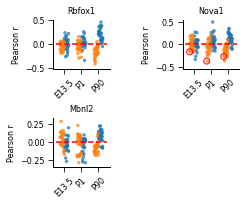

In [53]:
from itertools import product
from matplotlib.gridspec import GridSpec


rbp_list = ['Rbfox1', 'Nova1', 'Mbnl1']

fig = plt.figure(figsize=(8/2.4, 6.5/2.4))
gs = GridSpec(2,2)
gs.update(wspace=1.3, hspace=1)

i = 0

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1])
plot_rbp_ax_uniform('Rbfox1', ax1)
plot_rbp_ax_uniform('Nova1', ax2)
plot_rbp_ax_uniform('Mbnl2', ax3)
# plot_rbp_ax_uniform('Mbnl2', ax4)

ax2.scatter([-0.25, 0.75, 1.75],
           [nan_pearsonr(norm_expression.loc['Nova1', e13_cells], psix_object.adata.uns['psi'].loc[e13_cells, 'Nova1_1'])[0],
           nan_pearsonr(norm_expression.loc['Nova1', p1_cells], psix_object.adata.uns['psi'].loc[p1_cells, 'Nova1_1'])[0],
           nan_pearsonr(norm_expression.loc['Nova1', p90_cells], psix_object.adata.uns['psi'].loc[p90_cells, 'Nova1_1'])[0]],
           color="none", edgecolor="red")
#            c = 'darkred', linewidth=1, color=None)

# plt.show()  
plt.savefig('psix_output/plots/rbp_p90_module_correlations.png', bbox_inches='tight', res=20000, dpi =2000)

## Nova1 expression and splicing

<Figure size 432x288 with 0 Axes>

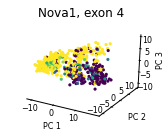

In [93]:
from matplotlib.gridspec import GridSpec
plt.tight_layout()
fig = plt.figure(figsize=(9*cm*0.75, 6.75*cm*0.75))
ax = fig.add_subplot(111, projection='3d')
# gs = GridSpec(1,5)
# gs.update(wspace=0.05, hspace=0.10)
# ax = fig.add_subplot(gs[0,0:4], projection='3d')
# ax_2 = fig.add_subplot(gs[0,4])
ax.grid(False)
ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3, c=psi.loc['Nova1_1'], s=10, linewidth=0, alpha=1)
# ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_3, c=colores)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


# ax.set_title('Mouse neurogenesis', fontsize=12)
ax.set_xlabel('PC 1', fontsize=8,labelpad=-5)
ax.set_ylabel('PC 2', fontsize=8,labelpad=-5)
ax.set_zlabel('PC 3', fontsize=8,labelpad=-8, rotation=90)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title('Nova1, exon 4', fontsize=12)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

#     plt.show()

plt.savefig('psix_output/plots/PCA_Nova1_1.png', bbox_inches='tight', res=20000, dpi =2000)

In [94]:
def plot_PC3_gene(gene):

    from matplotlib.gridspec import GridSpec
    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm*0.75, 6.75*cm*0.75))
    ax = fig.add_subplot(111, projection='3d')
    # gs = GridSpec(1,5)
    # gs.update(wspace=0.05, hspace=0.10)
    # ax = fig.add_subplot(gs[0,0:4], projection='3d')
    # ax_2 = fig.add_subplot(gs[0,4])
    ax.grid(False)
    ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3, c=norm_expression.loc[gene], s=10, linewidth=0, alpha=1, cmap='inferno',)
    # ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_3, c=colores)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)


    ax.set_title(gene, fontsize=8)
    ax.set_xlabel('PC 1', fontsize=8,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=8,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=8,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(gene + ', gene', fontsize=12)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    plt.savefig('psix_output/plots/PCA_' + gene + '.png', bbox_inches='tight', res=20000, dpi =2000)

<Figure size 432x288 with 0 Axes>

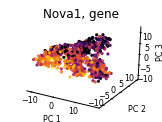

In [95]:
plot_PC3_gene('Nova1')

<Figure size 432x288 with 0 Axes>

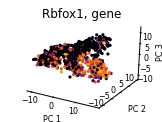

In [97]:
plot_PC3_gene('Rbfox1')

<Figure size 432x288 with 0 Axes>

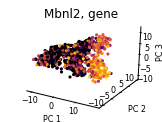

In [98]:
plot_PC3_gene('Mbnl2')

In [ ]:
# Effect of assumer capture efficiency in Psix score

In [4]:
psix_object = psix.Psix(psi_table = 'psix_output/psix_object/psi.tab.gz',
                        mrna_table = 'psix_output/psix_object/mrna.tab.gz')



psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.01)
psix_scores_01 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.02)
psix_scores_02 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.05)
psix_scores_05 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.1)
psix_scores_1 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.15)
psix_scores_15 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.2)
psix_scores_2 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.25)
psix_scores_25 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.3)
psix_scores_3 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.35)
psix_scores_35 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.4)
psix_scores_4 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.45)
psix_scores_45 = psix_object.psix_results

psix_object.run_psix(latent='data/pc3_rd.tab.gz', n_jobs=25, capture_efficiency = 0.5)
psix_scores_5 = psix_object.psix_results

Computing cell-cell metric...


100%|██████████| 1067/1067 [00:00<00:00, 5764.54it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:20<00:00, 100.14it/s]


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [08:57<00:00, 21.49s/it]  


Successfully estimated p-values


In [5]:
scores_df = pd.DataFrame()
scores_df['0.5'] = psix_scores_5.psix_score
scores_df['0.45'] = psix_scores_45.psix_score
scores_df['0.4'] = psix_scores_4.psix_score
scores_df['0.35'] = psix_scores_35.psix_score
scores_df['0.3'] = psix_scores_3.psix_score
scores_df['0.25'] = psix_scores_25.psix_score
scores_df['0.2'] = psix_scores_2.psix_score
scores_df['0.15'] = psix_scores_15.psix_score
scores_df['0.1'] = psix_scores_1.psix_score
scores_df['0.05'] = psix_scores_05.psix_score
scores_df['0.01'] = psix_scores_01.psix_score

scores_df.to_csv('psix_output/scores_different_capture_efficiency.tab.gz', sep='\t', index=True, header=True)

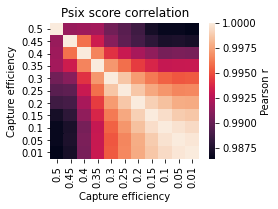

In [9]:
import seaborn as sns
fig = plt.figure(figsize=(8/2.4, 6/2.4))

sns.heatmap(scores_df.corr(), cbar_kws={'label': 'Pearson r'})
plt.xlabel('Capture efficiency')
plt.ylabel('Capture efficiency')

plt.title('Psix score correlation')

plt.savefig('psix_output/plots/scores_corr.png', bbox_inches='tight', res=20000, dpi =2000)
